In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# user defined module
import model_implementation_pipeline as mip
import features_transformation_pipeline as ftp
from scipy.sparse import hstack

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Loading Data

In [4]:
project_data = pd.read_csv('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/train_data.csv', nrows=50000)
resource_data = pd.read_csv('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/resources.csv')

## 2. Data Preprocessing

In [5]:
# Preprocessing the raw data
data = ftp.preprocess_data(project_data, resource_data)

In [6]:
# splitting the data into test, CV and training
X_train, X_cv, X_test, y_train, y_cv, y_test = mip.train_cv_test_split(data, 'project_is_approved')

In [7]:
# for fitting the data
ftp.feature_transformation_fit(X_train)

Index(['teacher_number_of_previously_posted_projects', 'price'], dtype='object') numerical columns
Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'clean_categories', 'clean_subcategories'],
      dtype='object') categorical columns


(StandardScaler(), OneHotEncoder(handle_unknown='ignore'))

In [9]:
# function to transform the features
def feature_transform(data):
    scaler = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/scaler.pkl', 'rb'))
    num = scaler.transform(data[scaler.feature_names_in_])
    ohe = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/ohe.pkl', 'rb'))
    cat = ohe.transform(data[ohe.feature_names_in_])
    essay_vectorize = ftp.avg_word_2vec(data)
    return num, cat, essay_vectorize
            

In [10]:
#calling above function to transform the data
X_train_num, X_train_cat, X_train_des = feature_transform(X_train)
X_cv_num, X_cv_cat, X_cv_des = feature_transform(X_cv)
X_test_num, X_test_cat, X_test_des = feature_transform(X_test)

# storing the features value together in CSR
X_tr = hstack((X_train_num, X_train_cat, X_train_des)).tocsr()
X_cr = hstack((X_cv_num, X_cv_cat, X_cv_des)).tocsr()
X_te = hstack((X_test_num, X_test_cat, X_test_des)).tocsr()

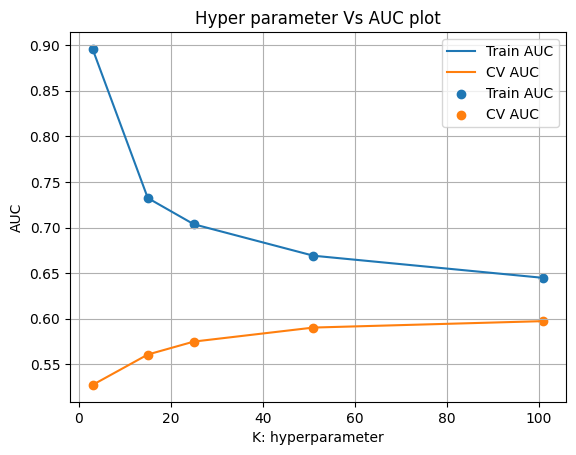

In [71]:
# Implementing KNN
neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors': [3, 15, 25, 51, 101]}

mip.evaluate_model(neigh, cv = 3, X_train_data = X_tr, y_train_data= y_train, param= parameters)

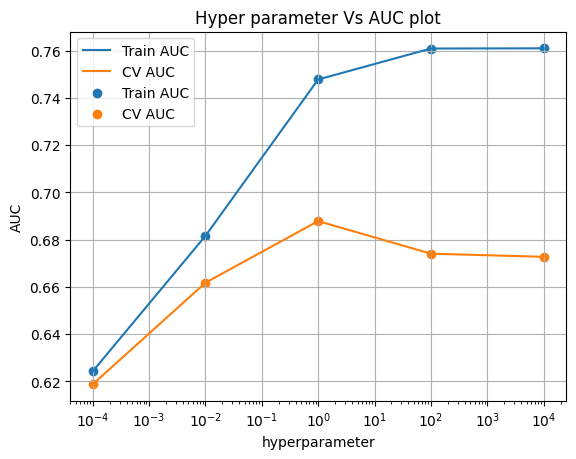

In [20]:
# Implementing Logistic Regression
log = LogisticRegression(max_iter= 1000)
parameters = {'C' : [0.0001, 0.01, 1.0, 100.0, 10000.0]}

mip.evaluate_model(log, cv = 3, X_train_data = X_tr, y_train_data= y_train, param= parameters)

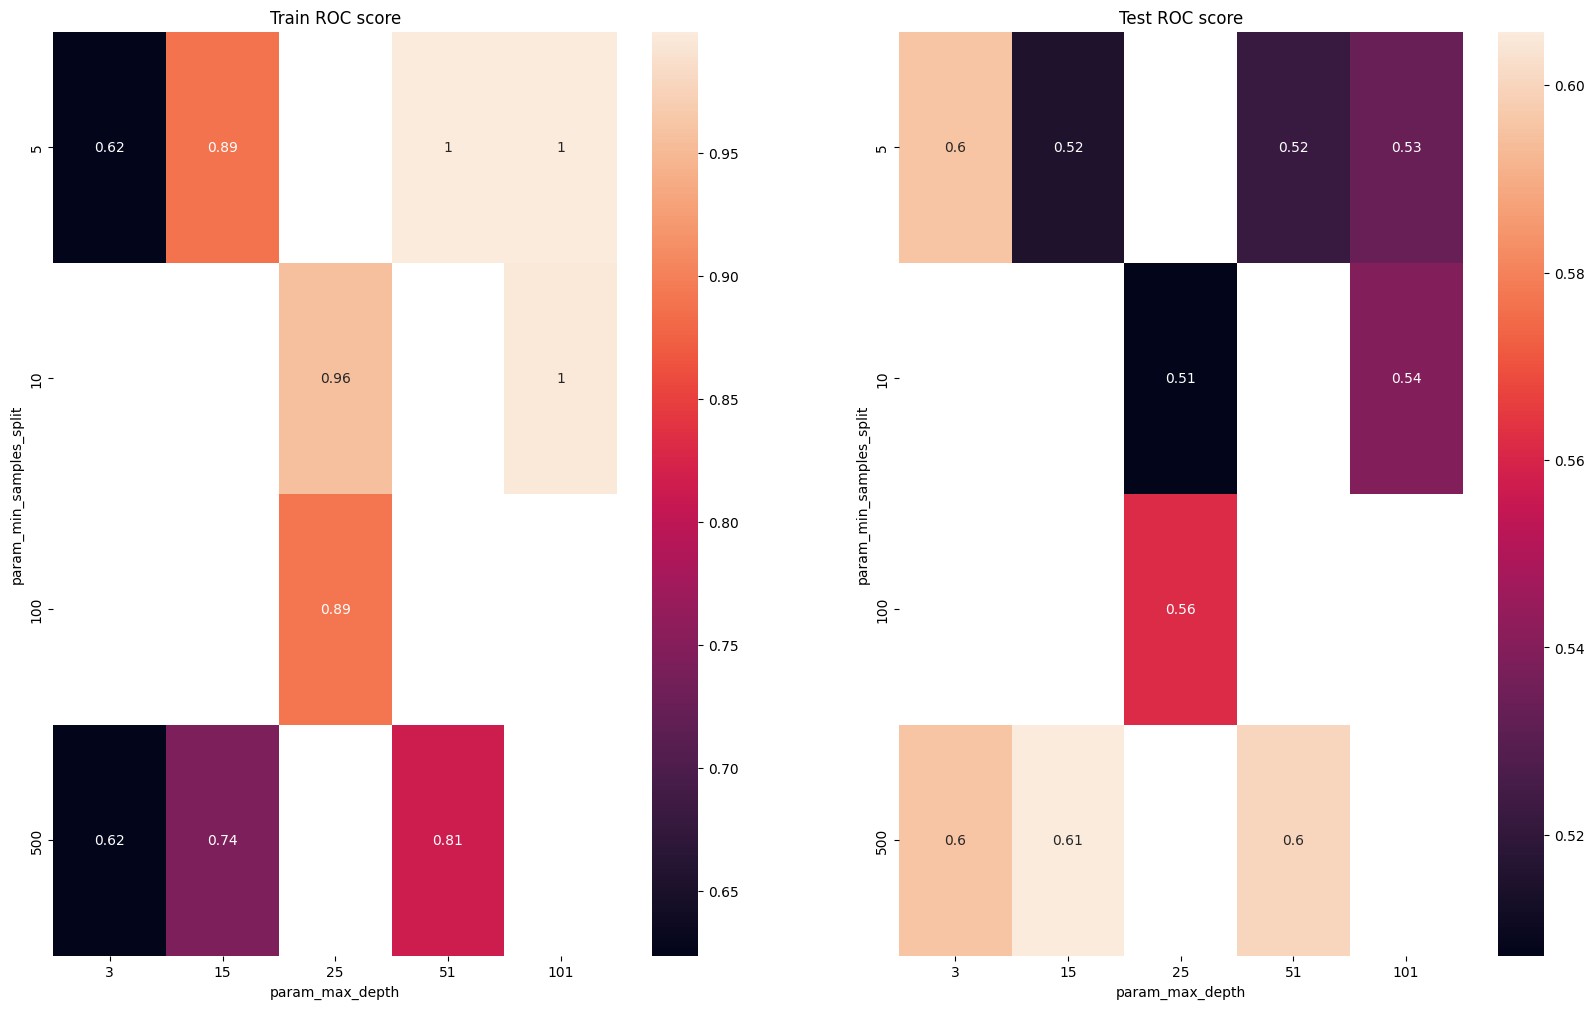

In [12]:
# Implementing Decision Tree for finding best parameters
dt = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth': [3, 15, 25, 51, 101],
         'min_samples_split': [5, 10, 100, 500]}
mip.evaluate_model(dt, cv = 3, X_train_data = X_tr, y_train_data= y_train, param= parameters)

In [17]:
# saving the model with the best parameters
mip.model_imp(95, 0.01, 15, 500, X_tr, y_train)

(KNeighborsClassifier(n_jobs=-1, n_neighbors=95),
 LogisticRegression(C=0.01, max_iter=1000, n_jobs=-1),
 DecisionTreeClassifier(max_depth=15, min_samples_split=500, random_state=0))

In [19]:
def best_threshold(X_train, y_train):
    log = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/LogisticRegression.pkl', 'rb'))
    y_train_pred_log = mip.batch_pred(log, X_train)

    knn = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/KNN.pkl', 'rb'))
    y_train_pred_knn = mip.batch_pred(knn, X_train)

    dt = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/DecisionTree.pkl', 'rb'))
    y_train_pred_dt = mip.batch_pred(dt, X_train)


    train_fpr_log, train_tpr_log, tr_thresholds_log = roc_curve(y_train, y_train_pred_log)

    train_fpr_knn, train_tpr_knn, tr_thresholds_knn = roc_curve(y_train, y_train_pred_knn)

    train_fpr_dt, train_tpr_dt, tr_thresholds_dt = roc_curve(y_train, y_train_pred_dt)

    best_t_log = mip.find_best_threshold(tr_thresholds_log, train_fpr_log, train_tpr_log)
    best_t_knn = mip.find_best_threshold(tr_thresholds_knn, train_fpr_knn, train_tpr_knn)
    best_t_dt = mip.find_best_threshold(tr_thresholds_dt, train_fpr_dt, train_tpr_dt)

    return best_t_log, best_t_knn, best_t_dt

In [20]:
best_threshold_log, best_threshold_knn, best_threshold_dt = best_threshold(X_tr, y_train)

the maximum value of tpr*(1-fpr) 0.40499191096521275 for threshold 0.839
the maximum value of tpr*(1-fpr) 0.3774743451195143 for threshold 0.853
the maximum value of tpr*(1-fpr) 0.4874874392759523 for threshold 0.856


In [23]:
def compare_model_conf_matrix(X_te, y_test, best_threshold_log, best_threshold_knn, best_threshold_dt):
    log = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/LogisticRegression.pkl', 'rb'))
    y_test_pred_log = mip.batch_pred(log, X_te)
    knn = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/KNN.pkl', 'rb'))
    y_test_pred_knn = mip.batch_pred(knn, X_te)
    dt = pickle.load(open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/DecisionTree.pkl', 'rb'))
    y_test_pred_dt = mip.batch_pred(dt, X_te)

    cm_test_log = confusion_matrix(y_test, mip.predict_with_best_t(y_test_pred_log, best_threshold_log))
    cm_test_knn = confusion_matrix(y_test, mip.predict_with_best_t(y_test_pred_knn, best_threshold_knn))
    cm_test_dt = confusion_matrix(y_test, mip.predict_with_best_t(y_test_pred_dt, best_threshold_dt))

    conf_matrix = {'LogisticRegression Test Confusion Matrix': cm_test_log,
               'KNN Test Confusion Matrix': cm_test_knn,
               'Decision Tree Classifier Confusion Matrix': cm_test_dt
               }
    
    conf_mat_list = conf_matrix.keys()
    fig, ax = plt.subplots(1,3, figsize=(20,12))
    row = 0
    col = 0
    for j, i in enumerate(conf_mat_list):
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix[i], display_labels = ['Proj. Not Approved', 'Proj. Approved'])
        cm_display.plot(ax=ax[col], colorbar=False)
        ax[col].title.set_text(f'{i}')
        col+=1

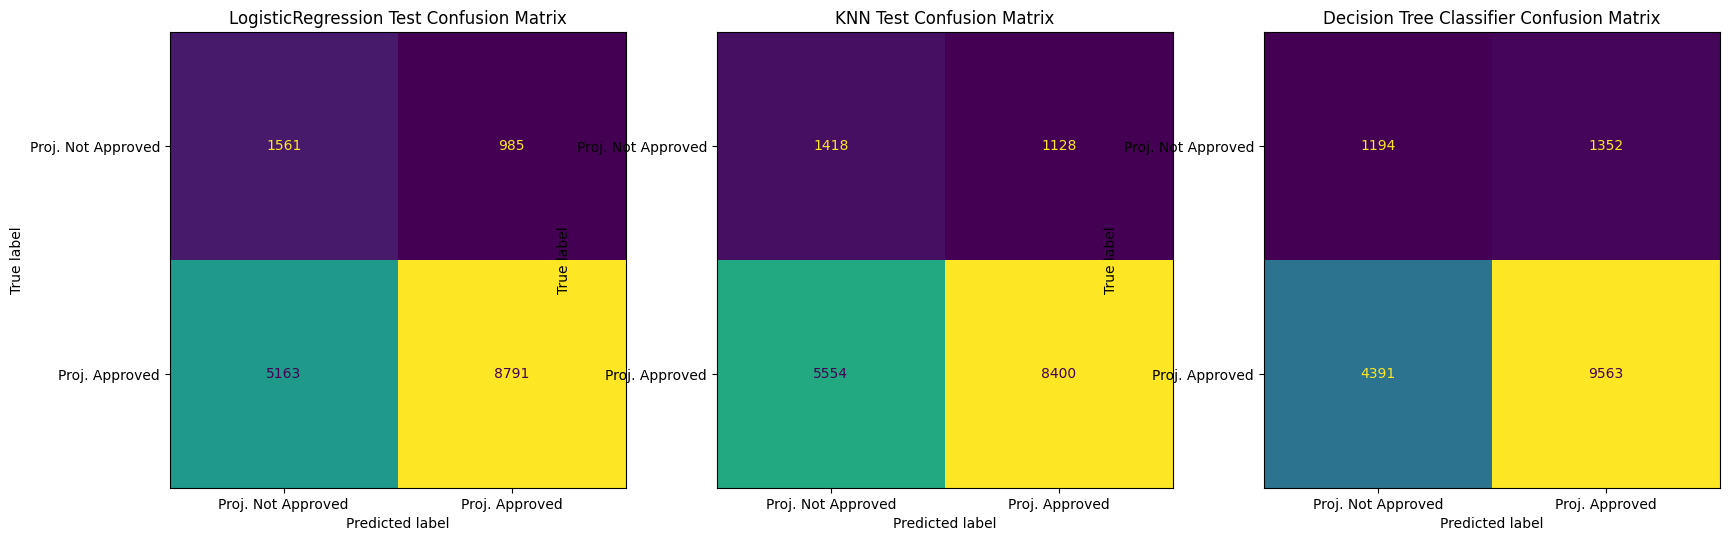

In [24]:
compare_model_conf_matrix(X_te, y_test, best_threshold_log, best_threshold_knn, best_threshold_dt)

Accoriding to the Confusion matrix: 
- TPR and TNR is higher for logistic regression, hence we will use Logistic regression model for our inference data